In [1]:
%pip install --upgrade uncertainties

Note: you may need to restart the kernel to use updated packages.


In [2]:
import caesar
import numpy as np
import astropy
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable, Table, Column
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
import seaborn as sns
import uncertainties as unc  
import uncertainties.unumpy as unumpy
from scipy.stats import binned_statistic_2d
import matplotlib

/home/sarah/anaconda3/lib/python3.9/site-packages/yt/utilities/logger.py:4: VisibleDeprecationWarning: The configuration file /home/sarah/.config/yt/ytrc is deprecated in favor of /home/sarah/.config/yt/yt.toml. Currently, both are present. Please manually remove the deprecated one to silence this warning.
Deprecated since v4.0.0. This feature will be removed in v4.1.0
  from yt.config import ytcfg


In [3]:
def get_properties(obj):
    ''' 
    Returns the properties x-ray luminosities, stellar mass, star formation rate, specific star formation rate, 
    black hole mass, and lambda for every galaxy in the input file with stellar mass greater than 10^10 solar masses

        Parameters:
                obj : Caesar read infile
                      

        Returns:
                          Lx : array_like
                               An array of x-ray luminosities
                stellar_mass : array_like
                               An array of stellar masses
                         SFR : array_like
                               An array of star formation rates
                        sSFR : array_like
                               An array of specific star formation rates
                     bh_mass : array_like
                               An array of black hole masses
                       lmbda : array_like
                               An array of lambda
                        Ledd : array_like
                               An array of eddington accretion
    '''
    
    # get Lx
    # get an array of all bhmdot and bh_fedd
    accretion_rates = [i.bhmdot for i in obj.galaxies]
    eddington_ratio = [i.bh_fedd for i in obj.galaxies]

    # extract data into array
    bhmdot = np.array(accretion_rates)
    bh_fedd = np.array(eddington_ratio)
    
    # finding Ledd
    Ledd = bhmdot/bh_fedd
    
    # finding the bolometric luminosities
    # array with shape bhmdot of Lbols using the first equation (fedd > 0.1) for all values
    Er = 0.1
    Lbol = ((Er/(1-Er))*bhmdot*(u.M_sun/u.yr)*(const.c**2))
    
    # replacing the indices where fedd < 0.1 with values using the other equation
    # this retains the units
    Lbol[bh_fedd < 0.1] = (10*bh_fedd[bh_fedd < 0.1])*Er*bhmdot[bh_fedd < 0.1]*(u.M_sun/u.yr)*(const.c**2)
    
    # finds the bolometric correction
    BC = 10.83*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(0.28)) + 6.08*((Lbol.to('L_sun')/(10**(10)*u.L_sun))**(-0.02))
    
    # finding the hard x-ray luminosity in terms of Lsun
    # have to use just the value of Lbol_sun then add it back on because np.log10 only works on dimensionless quantities
    # it then converts to erg/s
    Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
    
    #making it unitless
    Lx = Lx_ergs.value
    
    
    
    
    # extract galaxy mass data
    galaxy_masses = [i.masses['stellar'] for i in obj.galaxies]
    all_sm = np.array(galaxy_masses)
    sm_gt10 = (all_sm > 10**10)
    stellar_mass = all_sm[sm_gt10]
    
    # masking Lx for corresponding stellar masses > 10^10
    Lx = Lx[sm_gt10]
    
    # masking Ledd for corresponding stellar masses > 10^10
    Ledd = Ledd[sm_gt10]
    
    # masking fedd for corresponding stellar masses > 10^10
    bh_fedd = bh_fedd[sm_gt10]
    
    bhmdot = bhmdot[sm_gt10]
    
    # extract star formation rates data
    galaxy_SFRs = [i.sfr for i in obj.galaxies]
    SFR = np.array(galaxy_SFRs)
    SFR = SFR[sm_gt10]
    
    # extract black hole mass data
    bh_masses = [i.masses['bh'] for i in obj.galaxies]
    bh_mass = np.array(bh_masses)
    bh_mass = bh_mass[sm_gt10]
    
    # calculate specific star formation rate
    sSFR = SFR/stellar_mass
    
    # calculating lambda
    lmbda = 25.0*Lx / (1.3e38*0.002*stellar_mass)  
    
    
    return Lx, stellar_mass, SFR, sSFR, bh_mass, lmbda, Ledd, bh_fedd, bhmdot

In [4]:
# a list of the different redshifted files I want to load (box size 100)
files = ['m100n1024_056.hdf5',
'm100n1024_066.hdf5',
'm100n1024_074.hdf5',
'm100n1024_084.hdf5',
'm100n1024_097.hdf5',
'm100n1024_114.hdf5',
'm100n1024_137.hdf5']
files.reverse()

In [5]:
def get_all_r():
    # define input file
    # box 25
    #folder_path = '/disk04/rad/sim/m25n256/s50/Groups/' 
    #box 100
    folder_path = '/disk04/rad/sim/m100n1024/s50/Groups/'

    # empty dictionary to place redshift table data into
    all_r = {}

    for filename in files:
        # load in input file
        obj = caesar.load(os.path.join(folder_path, filename))

        # obtaining the properties
        Lx, sm, SFR, sSFR, bhm, lmbda, Ledd, fedd, BHAR = get_properties(obj)

        # finding the z label
        label = filename.split('m100n1024_')[1].split('.hdf5')[0]

        # creating a table for each redshift, putting it in the empty dictionary, and naming them
        name = str('z') + str(label)
        all_r[name] = astropy.table.Table([Lx, sm, SFR, sSFR, bhm, lmbda, Ledd, fedd, BHAR], 
                                          names=('Lx', 'sm', 'SFR', 'sSFR', 'bhm', 'lambda', 'Ledd', 'fedd', 'BHAR'))
        
    return all_r
    

    

In [6]:
def find_fracs(lambdas, Lx):
    '''
    Finds the percentage of galaxies with lambda greater than 0.01 and 0.1 AND Lx greater than 10^42 for a given set 
    of galaxies defined by their input log lambdas.
    
    Parameters:
                lambdas : array_like
                          An array of log(lambdas)
                      

        Returns:
                frac_gt2 : float
                           The percentage of galaxies with lambda greater than 0.01 AND Lx greater than 10^42
                frac_gt1 : float
                           The percentage of galaxies with lambda greater than 0.1 AND Lx greater than 10^42
                           
    
    '''
    mask2 = (lambdas > -2) & (Lx > 1e42)
    l_gr2 = lambdas[mask2]
            
    if len(l_gr2) == 0:
        #print('there are no lambdas>0.01')
        frac_gt2 = float('NaN')
    else:
        frac_gt2 = (len(l_gr2)/len(lambdas))*100

    mask1 = (lambdas > -1) & (Lx > 1e42)
    l_gr1 = lambdas[mask1]

    if len(l_gr1) == 0:
        #print('there are no lambdas>0.1')
        frac_gt1 = float('Nan')
    else:
        frac_gt1 = (len(l_gr1)/len(lambdas))*100

    #print(frac_gt2)
    #print(frac_gt1)
    
    return frac_gt2, frac_gt1

In [7]:
#0.01
z = [0.25, 0.75, 1.25, 1.75, 2.25]
jSFR_bins = np.reshape(np.flip(np.array([2.525, 1.98, 1.289, 0.32, -0.703, 2.126, 1.739, 0.98, -0.017, 
          -1.022, 1.833, 1.433, 0.703, -0.378, -1.519, 1.564, 1.088, 0.467, 
          -0.716, -1.932, 1.196, 0.651, 0.08, -0.884, -2.636])), (5,5))
jAGN_fracs_gt2 = np.reshape(np.flip(np.array([23.992, 12.484, 23.354, 13.015, 10.793, 9.974, 10.638,
         16.218, 8.192, 4.12, 9.142, 6.743, 13.323, 4.89, 2.501,
         5.931, 3.617, 5.843, 1.469, 0.934, 3.525, 1.153, 0.696,
         0.418, 0.218])), (5,5))
#0.1
jAGN_fracs_gt1 = np.reshape(np.flip(np.array([13.02, 2.62, 7.133, 3.277, 1.071, 2.87, 1.598, 3.611, 1.349,
          0.4, 2.335, 1.025, 1.635, 0.414, 0.144, 1.48, 0.249, 0.387,
          0.148, 0.025, 0.905, 0.056, 0.046, 0.085, 0.027])), (5,5))

lo_err_gt1 = np.array([2.505, 0.336, 1.089, 0.895, 0.407, 0.445, 0.166, 0.477, 0.283, 0.128, 0.337,
                       0.099, 0.271, 0.109, 0.053, 0.294, 0.037, 0.089, 0.05, 0.014, 0.417, 0.03,
                       0.03, 0.054, 0.018])
hi_err_gt1 = np.array([2.631, 0.392, 1.26, 1.091, 0.57, 0.508, 0.17, 0.57, 0.316, 0.183, 0.389, 0.103,
                       0.318, 0.135, 0.074, 0.368, 0.045, 0.12, 0.077, 0.027, 0.754, 0.053, 0.068,
                       0.144, 0.048])



lo_err_gt2 = np.array([3.788, 1.278, 2.644, 2.957, 2.586, 1.641, 0.796, 1.69, 1.202, 0.843, 1.242,
                       0.381, 1.063, 0.678, 0.423, 0.814, 0.214, 0.492, 0.277, 0.169, 1.189, 0.208,
                       0.196, 0.182, 0.082])
hi_err_gt2 = np.array([4.416, 1.335, 2.808, 3.261, 3.153, 1.675, 0.784, 1.791, 1.245, 0.947, 1.379,
                       0.402, 1.124, 0.788, 0.501, 0.897, 0.218, 0.492, 0.327, 0.198, 1.544, 0.229,
                       0.25, 0.284,0.125])


lo_err_gt1 = np.flip(lo_err_gt1)
lo_err_gt2 = np.flip(lo_err_gt2)

hi_err_gt1 = np.flip(hi_err_gt1)
hi_err_gt2 = np.flip(hi_err_gt2)
#print(np.split(lo_err_gt1, 5))

lo_err_gt1 = np.split(lo_err_gt1, 5)
lo_err_gt2 = np.split(lo_err_gt2, 5)

hi_err_gt1 = np.split(hi_err_gt1, 5)
hi_err_gt2 = np.split(hi_err_gt2, 5)

err_bounds_allz = []
lo_bounds_allz = []
up_bounds_allz = []
for z in range(len(jAGN_fracs_gt2)):
    jfracs2_lo = unumpy.uarray((jAGN_fracs_gt2[z], lo_err_gt2[z]))  
    jfracs1_lo = unumpy.uarray((jAGN_fracs_gt1[z], lo_err_gt1[z]))
    vari_lo = jfracs1_lo/jfracs2_lo
    prop_err_lo = unumpy.std_devs(vari_lo)

    jfracs2_hi = unumpy.uarray((jAGN_fracs_gt2[z], hi_err_gt2[z]))  
    jfracs1_hi = unumpy.uarray((jAGN_fracs_gt1[z], hi_err_gt1[z]))
    vari_hi = jfracs1_hi/jfracs2_hi
    prop_err_hi = unumpy.std_devs(vari_hi)

    err_bounds = np.vstack((prop_err_lo,prop_err_hi))
    
    lo_bounds = jAGN_fracs_gt1[z]/jAGN_fracs_gt2[z] - err_bounds[0]
    up_bounds = jAGN_fracs_gt1[z]/jAGN_fracs_gt2[z] + err_bounds[1]
    
    err_bounds_allz.append(err_bounds)
    lo_bounds_allz.append(lo_bounds)
    up_bounds_allz.append(up_bounds)

/tmp/ipykernel_490824/1671783491.py:49: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  jfracs2_lo = unumpy.uarray((jAGN_fracs_gt2[z], lo_err_gt2[z]))
/tmp/ipykernel_490824/1671783491.py:50: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  jfracs1_lo = unumpy.uarray((jAGN_fracs_gt1[z], lo_err_gt1[z]))
/tmp/ipykernel_490824/1671783491.py:54: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirectory.
  jfracs2_hi = unumpy.uarray((jAGN_fracs_gt2[z], hi_err_gt2[z]))
/tmp/ipykernel_490824/1671783491.py:55: UserWarning: Obsolete: uarray() should now be called with two arguments. Code can be automatically updated with python -m uncertainties.1to2 -w ProgramDirector

In [8]:
all_r = get_all_r()
#print(all_r)

yt : [INFO     ] 2023-03-13 12:01:11,425 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_137.hdf5
yt : [INFO     ] 2023-03-13 12:01:11,867 Found 482650 halos
yt : [INFO     ] 2023-03-13 12:01:12,129 Found 49752 galaxies
/tmp/ipykernel_490824/4053297392.py:37: RuntimeWarning: invalid value encountered in true_divide
  Ledd = bhmdot/bh_fedd
/home/sarah/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_490824/4053297392.py:54: RuntimeWarning: divide by zero encountered in log10
  Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
yt : [INFO     ] 2023-03-13 12:01:15,308 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_114.hdf5
yt : [INFO     ] 2023-03-13 12:01:15,640 Found 517907 halos
yt : [INFO     ] 2023-03-13 12:01:15,975 Found 41585 galaxies
yt : [INFO     ] 2023-03-13 12:01:18,307

In [9]:
def agn_fracs(sigma):
    
        #all_r = get_all_r()
        z = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5]

        # lists to store the 6 agn fractions (each redshift)
        AGN_fracs_gt2 = []
        AGN_fracs_gt1 = []

        # list to store the 6 sfr bin midpoints for plotting
        SFR_bins = []

        #iterating across each redshift
        for count, key in enumerate(all_r):

            #
            AGN_frac_per_bin_gt2 = np.array([])
            AGN_frac_per_bin_gt1 = np.array([])

            #extract xray luminosities to make mask Lx> 10^42
            Lx = all_r[key]['Lx'].copy()

            no_zeros = (Lx!=0)

            Lx = Lx[no_zeros]

            sm = all_r[key]['sm'][no_zeros].copy()
            logsm = np.log10(sm.data)

            # NEW WAY: binning the mass data
            #extracting the sfrs for this redshift
            SFRs_all = all_r[key]['SFR'][no_zeros].copy()
            SFRs = SFRs_all

            #creating an empty array with the size equal to the amount of 0 sfr values
            rand_sams = np.zeros(SFRs[SFRs == 0].shape)

            #filling the empty array with random numbers ranging between 0.000001 and 0.00001
            for i in range(len(rand_sams)):
                rand_sams[i] = np.random.uniform(1e-3, 1e-2)

            #replacing 0 sfr values with the randomly sampled low values
            SFRs[SFRs == 0] = rand_sams

            #logging the full sfr array with 0 values replaced
            logSFRs = np.log10(np.asarray(SFRs))

            #calculating relative MS values
            logSFR_MS = logSFRs + 7.6 - 0.76*logsm - 2.95*np.log10(1+z[count])

            #defining bin boundaries
            bins = [np.inf, 0.15, -0.4, -0.95, -np.inf]

            #binning data based on relative MS values
            digitized = np.digitize(logSFR_MS, bins)

            # finding plotting points
            SFRs_midpoints = np.array([])

            # iterating across each bin
            for i in range(1, len(bins)):
                # finding the lambdas in a certain bin
                lmbda = all_r[key]['lambda'][no_zeros].copy()
                lambdas = np.log10(lmbda[digitized == i])

                #plt.hist(lambdas, bins=100)
                #plt.show()


                '''        
                #ADDING SCATTER
                '''
                mu = np.mean(lambdas)
                #sigma = sigma

                #print('loglams:', lambdas)
                #print('mean:', mu)
                #print('stdev:', sigma)

                #print(lambdas.size)
                np.random.seed(999)
                new_lambdas = lambdas + np.random.normal(0, sigma, lambdas.size)
                #new_lambdas = np.random.poisson(mu, lambdas.size)


                # finding the Lxs in a certain bin
                Lx_binned = Lx[digitized == i]
                # finding the agn fractions (2) for a certain bin
                frac_gt2, frac_gt1 = find_fracs(new_lambdas, Lx_binned)

                #binning sfrs
                sfr_binned = logSFRs[digitized == i]
                SFRs_midpoints = np.append(SFRs_midpoints, np.median(sfr_binned))

                #adding the agn fraction of each bin to an array length 5 (no of bins)
                AGN_frac_per_bin_gt2 = np.append(AGN_frac_per_bin_gt2, frac_gt2)
                AGN_frac_per_bin_gt1 = np.append(AGN_frac_per_bin_gt1, frac_gt1)



            SFR_bins.append(SFRs_midpoints)
            # adding the certain redshifts agn fraction for each bin, into an array length 6 (no of redshifts)
            AGN_fracs_gt2.append(AGN_frac_per_bin_gt2)
            AGN_fracs_gt1.append(AGN_frac_per_bin_gt1)
            
            #this might not work becayse the redshift lists are different lengths
            #fracs2 = np.array(AGN_fracs_gt2)
            #fracs1 = np.array(AGN_fracs_gt1)
            
            #variations = fracs1/fracs2
            #print(variations)
            
        return AGN_fracs_gt2, AGN_fracs_gt1, SFR_bins

In [10]:
def interpolate(xdata, ydata, x_poi):
    diff = np.abs(xdata - x_poi)
    closest_i = np.argsort(diff)[:2]
    p = np.polyfit(xdata[closest_i], ydata[closest_i], 1)
    y_poi = p[0]*x_poi + p[1]
    
    return y_poi

In [11]:
def find_expecteds(xdata, jxdata, jydata):
    y_exp = []
    for z, x_z in enumerate(xdata[:5]):
        #variations = AGN_fracs_gt1[z]/AGN_fracs_gt2[z]
        y_exp_per_z = []
        for point in x_z:
            y_exp_per_z.append(interpolate(jxdata[z], jydata[z], point))

        y_exp.append(y_exp_per_z)

    return(y_exp)

In [12]:
def get_data(sigma):
        AGN_fracs_gt2, AGN_fracs_gt1, xdata = agn_fracs(sigma)
        jydata = jAGN_fracs_gt1/jAGN_fracs_gt2
        jxdata = jSFR_bins

        y_exp = find_expecteds(xdata, jxdata, jydata)
        lo_bound_exp = np.asarray(find_expecteds(xdata, jxdata, lo_bounds_allz))
        up_bound_exp = np.asarray(find_expecteds(xdata, jxdata, up_bounds_allz))

        #print(lo_bound_exp)
        #print(up_bound_exp)
        exp_errs = np.diff(np.array([lo_bound_exp, up_bound_exp]), axis=0)/2
        #print(exp_errs)
        
        
        #print(AGN_fracs_gt1)
        #print(AGN_fracs_gt2)
        variations = np.asarray([AGN_fracs_gt1])[:, :5]/np.asarray([AGN_fracs_gt2])[:, :5]
        #print(variations)
        
        return y_exp, exp_errs, variations


In [13]:
history = []
store = []
def callback_f(x):
    return 
    #y = chi_squared(x)
    #history.append([x,y])

In [14]:
def chi_squared(sigma, z):
    #print(sigma)
    
    y_exp, y_err, y_model = get_data(sigma)
    #y_model = func of x using sigma
    #print('yexp', y_exp[1])
    #print('ymod', y_model[0][0])
    #print('yerr', y_err[0][0])
    #for i in y_model[0][0]:
    #    if i == np.nan:
    #        i = 0
    nans = np.argwhere(np.isnan(y_model[0][z]))
    #print(nans)
    #y_exp = y_exp[0]
    #y_model = y_model[0][0]
    #y_err = y_err[0][0]
    
    y_exp = np.delete(y_exp[z], nans)
    y_model = np.delete(y_model[0][z], nans)
    y_err = np.delete(y_err[0][z], nans)
    
    #print('yexp', y_exp)
    #print('ymod', y_model)
    #print('yerr', y_err)
        
    chi = np.sum(((y_exp - y_model)/y_err)**2)
    if sigma == np.nan:
        chi = 1000
    #print(chi)
    
    #store.append([sigma, chi])
    return chi



In [15]:
def total_chi(sigma):
    z = [1,2,3,4]
    chi = np.array([])
    for i in z:
        chi = np.append(chi, chi_squared(sigma, i))
        
    total = np.sum(chi)
    #print(total)
    store.append([sigma, total])
    
    return total

In [16]:
print(total_chi(0.4))

316.95079541577724


In [17]:



sigma_init = 0.263
result = scipy.optimize.minimize(total_chi, sigma_init, bounds=[[0.2, 0.3]], method='L-BFGS-B', options={'eps':0.0001})

print(result)

      fun: 255.64220153693532
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.263])


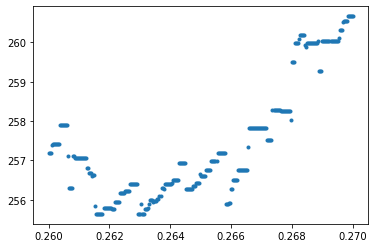

In [18]:
store=[]
a = np.linspace(0.26, 0.27, 300)
for i in a:
    total_chi(i)
#print(store)
values = np.asarray(store)
plt.plot(values[:,0], values[:,1], '.')

In [19]:
print(np.min(values[:,1]))

255.64220153693532


In [10]:
import colorsys

def scale_lightness(rgb, scale_l):
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

orange = matplotlib.colors.ColorConverter.to_rgb("#ff7f0e")
#blue = matplotlib.colors.ColorConverter.to_rgb("#1f77b4")
green = matplotlib.colors.ColorConverter.to_rgb("#2ca02c")
#purple = matplotlib.colors.ColorConverter.to_rgb("#9467bd")
#red = matplotlib.colors.ColorConverter.to_rgb('#d62728')
#pink = matplotlib.colors.ColorConverter.to_rgb('#e377c2')

blue = matplotlib.colors.ColorConverter.to_rgb('blue')
purple = matplotlib.colors.ColorConverter.to_rgb("darkviolet")
pink = matplotlib.colors.ColorConverter.to_rgb('fuchsia')
red = matplotlib.colors.ColorConverter.to_rgb('red')

In [11]:
AGN_fracs_gt2, AGN_fracs_gt1, SFR_bins = agn_fracs(0.263)
AGN_fracs_gt20, AGN_fracs_gt10, SFR_bins0 = agn_fracs(0)

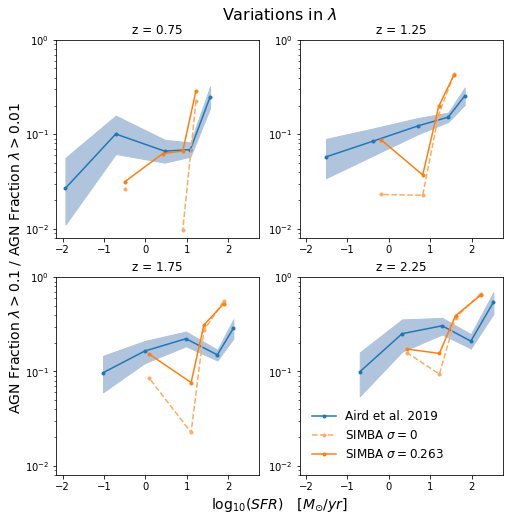

In [22]:
fig, ((ax2, ax3), (ax4, ax5)) = plt.subplots(2, 2, sharex='all', sharey='all', figsize=(8,8))

ax2.plot(jSFR_bins[1],  jAGN_fracs_gt1[1]/jAGN_fracs_gt2[1], linestyle='-', color='#1f77b4', marker='.', label='Aird et al. 2019')
ax2.fill_between(jSFR_bins[1], lo_bounds_allz[1], up_bounds_allz[1], color='lightsteelblue')

ax3.plot(jSFR_bins[2],  jAGN_fracs_gt1[2]/jAGN_fracs_gt2[2], linestyle='-', color='#1f77b4', marker='.')
ax3.fill_between(jSFR_bins[2], lo_bounds_allz[2], up_bounds_allz[2], color='lightsteelblue')

ax4.plot(jSFR_bins[3],  jAGN_fracs_gt1[3]/jAGN_fracs_gt2[3], linestyle='-', color='#1f77b4', marker='.')
ax4.fill_between(jSFR_bins[3], lo_bounds_allz[3], up_bounds_allz[3], color='lightsteelblue')

ax5.plot(jSFR_bins[4],  jAGN_fracs_gt1[4]/jAGN_fracs_gt2[4], linestyle='-', color='#1f77b4', marker='.')
ax5.fill_between(jSFR_bins[4], lo_bounds_allz[4], up_bounds_allz[4], color='lightsteelblue')

ax2.plot(SFR_bins0[1],  AGN_fracs_gt10[1]/AGN_fracs_gt20[1], linestyle='--', color=scale_lightness(orange, 1.3), marker='.', label='SIMBA $\sigma = 0$')
ax3.plot(SFR_bins0[2],  AGN_fracs_gt10[2]/AGN_fracs_gt20[2], linestyle='--', color=scale_lightness(orange, 1.3), marker='.')
ax4.plot(SFR_bins0[3],  AGN_fracs_gt10[3]/AGN_fracs_gt20[3], linestyle='--',  color=scale_lightness(orange, 1.3), marker='.')
ax5.plot(SFR_bins0[4],  AGN_fracs_gt10[4]/AGN_fracs_gt20[4], linestyle='--', color=scale_lightness(orange, 1.3), marker='.')

ax2.plot(SFR_bins[1],  AGN_fracs_gt1[1]/AGN_fracs_gt2[1], linestyle='-', color='#ff7f0e', marker='.', label='SIMBA $\sigma = 0.263$')
ax3.plot(SFR_bins[2],  AGN_fracs_gt1[2]/AGN_fracs_gt2[2], linestyle='-', color='#ff7f0e', marker='.')
ax4.plot(SFR_bins[3],  AGN_fracs_gt1[3]/AGN_fracs_gt2[3], linestyle='-',  color='#ff7f0e', marker='.')
ax5.plot(SFR_bins[4],  AGN_fracs_gt1[4]/AGN_fracs_gt2[4], linestyle='-', color='#ff7f0e', marker='.')

ax2.set_title('z = 0.75')
ax3.set_title('z = 1.25')
ax4.set_title('z = 1.75')
ax5.set_title('z = 2.25')

ax2.set_yscale('log')
ax2.set_ylim(top=10**0, bottom=0.008)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("$\log_{10}(SFR) \quad [M_{\odot}/yr]$", fontsize=14)
plt.ylabel("AGN Fraction $\lambda > 0.1$ / AGN Fraction $\lambda > 0.01$", fontsize=14, labelpad=10)
plt.title('Variations in $\lambda$', fontsize=16, pad=20)

ax2.tick_params('x', labelbottom=True, labelleft=True)
#ax2.tick_params('both', labelbottom=True, labelleft=True)
ax3.tick_params('both', labelbottom=True, labelleft=True)
ax4.tick_params('both', labelbottom=True, labelleft=True)
ax5.tick_params('both', labelbottom=True, labelleft=True)


fig.legend(bbox_to_anchor=(0.55, 0.13), loc='lower left', fontsize=12, frameon=False)
plt.show()

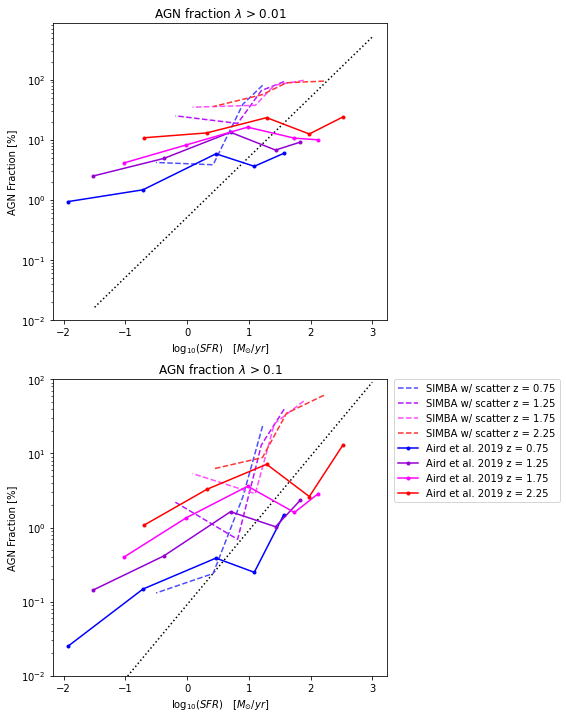

In [23]:
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.plot(SFR_bins_x, y2, ':', color='k')
ax1.plot(SFR_bins[1],  AGN_fracs_gt2[1], linestyle='--', color=scale_lightness(blue, 1.3),  label=' SIMBA w/ scatter z = 0.75')
ax1.plot(SFR_bins[2],  AGN_fracs_gt2[2], linestyle='--', color=scale_lightness(purple, 1.3),  label='SIMBA w/ scatter z = 1.25')
ax1.plot(SFR_bins[3],  AGN_fracs_gt2[3], linestyle='--', color=scale_lightness(pink, 1.3), label='SIMBA w/ scatter z = 1.75')
ax1.plot(SFR_bins[4],  AGN_fracs_gt2[4], linestyle='--', color=scale_lightness(red, 1.2),  label='SIMBA w/ scatter z = 2.25')

ax1.plot(jSFR_bins[1],  jAGN_fracs_gt2[1], linestyle='-', color=blue, marker='.', label='Aird et al. 2019 z = 0.75')
ax1.plot(jSFR_bins[2],  jAGN_fracs_gt2[2], linestyle='-', color=purple, marker='.', label='Aird et al. 2019 z = 1.25')
ax1.plot(jSFR_bins[3],  jAGN_fracs_gt2[3], linestyle='-', color=pink, marker='.', label='Aird et al. 2019 z = 1.75')
ax1.plot(jSFR_bins[4],  jAGN_fracs_gt2[4], linestyle='-', color=red, marker='.', label='Aird et al. 2019 z = 2.25')


ax1.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $\lambda$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

ax2.plot(SFR_bins_x, y1, ':', color='k')
ax2.plot(SFR_bins[1],  AGN_fracs_gt1[1], linestyle='--', color=scale_lightness(blue, 1.3),  label='SIMBA w/ scatter z = 0.75')
ax2.plot(SFR_bins[2],  AGN_fracs_gt1[2], linestyle='--', color=scale_lightness(purple, 1.3), label='SIMBA w/ scatter z = 1.25')
ax2.plot(SFR_bins[3],  AGN_fracs_gt1[3], linestyle='--', color=scale_lightness(pink, 1.3), label='SIMBA w/ scatter z = 1.75')
ax2.plot(SFR_bins[4],  AGN_fracs_gt1[4], linestyle='--', color=scale_lightness(red, 1.2), label='SIMBA w/ scatter z = 2.25')

ax2.plot(jSFR_bins[1],  jAGN_fracs_gt1[1], linestyle='-', color=blue, marker='.', label='Aird et al. 2019 z = 0.75')
ax2.plot(jSFR_bins[2],  jAGN_fracs_gt1[2], linestyle='-', color=purple, marker='.', label='Aird et al. 2019 z = 1.25')
ax2.plot(jSFR_bins[3],  jAGN_fracs_gt1[3], linestyle='-', color=pink, marker='.', label='Aird et al. 2019 z = 1.75')
ax2.plot(jSFR_bins[4],  jAGN_fracs_gt1[4], linestyle='-', color=red, marker='.', label='Aird et al. 2019 z = 2.25')


ax2.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $\lambda$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

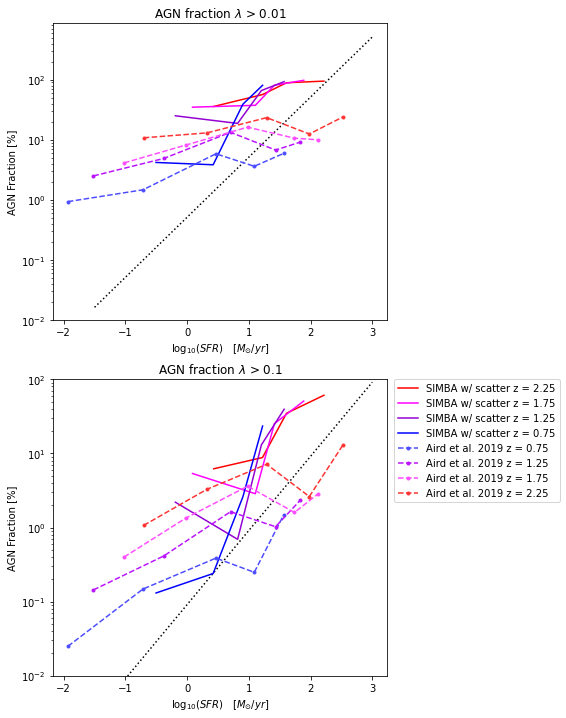

In [24]:
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.plot(SFR_bins_x, y2, ':', color='k')
ax1.plot(SFR_bins[4],  AGN_fracs_gt2[4], linestyle='-', color=red,  label='SIMBA w/ scatter z = 2.25')
ax1.plot(SFR_bins[3],  AGN_fracs_gt2[3], linestyle='-', color=pink, label='SIMBA w/ scatter z = 1.75')
ax1.plot(SFR_bins[2],  AGN_fracs_gt2[2], linestyle='-', color=purple,  label='SIMBA w/ scatter z = 1.25')
ax1.plot(SFR_bins[1],  AGN_fracs_gt2[1], linestyle='-', color=blue,  label=' SIMBA w/ scatter z = 0.75')




ax1.plot(jSFR_bins[1],  jAGN_fracs_gt2[1], linestyle='--', color=scale_lightness(blue, 1.3), marker='.', label='Aird et al. 2019 z = 0.75')
ax1.plot(jSFR_bins[2],  jAGN_fracs_gt2[2], linestyle='--', color=scale_lightness(purple, 1.3), marker='.', label='Aird et al. 2019 z = 1.25')
ax1.plot(jSFR_bins[3],  jAGN_fracs_gt2[3], linestyle='--', color=scale_lightness(pink, 1.3), marker='.', label='Aird et al. 2019 z = 1.75')
ax1.plot(jSFR_bins[4],  jAGN_fracs_gt2[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax1.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $\lambda$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

ax2.plot(SFR_bins_x, y1, ':', color='k')
ax2.plot(SFR_bins[4],  AGN_fracs_gt1[4], linestyle='-', color=red, label='SIMBA w/ scatter z = 2.25')
ax2.plot(SFR_bins[3],  AGN_fracs_gt1[3], linestyle='-', color=pink, label='SIMBA w/ scatter z = 1.75')
ax2.plot(SFR_bins[2],  AGN_fracs_gt1[2], linestyle='-', color=purple, label='SIMBA w/ scatter z = 1.25')
ax2.plot(SFR_bins[1],  AGN_fracs_gt1[1], linestyle='-', color=blue,  label='SIMBA w/ scatter z = 0.75')




ax2.plot(jSFR_bins[1],  jAGN_fracs_gt1[1], linestyle='--', color=scale_lightness(blue, 1.3),  marker='.', label='Aird et al. 2019 z = 0.75')
ax2.plot(jSFR_bins[2],  jAGN_fracs_gt1[2], linestyle='--', color=scale_lightness(purple, 1.3),  marker='.', label='Aird et al. 2019 z = 1.25')
ax2.plot(jSFR_bins[3],  jAGN_fracs_gt1[3], linestyle='--', color=scale_lightness(pink, 1.3),  marker='.', label='Aird et al. 2019 z = 1.75')
ax2.plot(jSFR_bins[4],  jAGN_fracs_gt1[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax2.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $\lambda$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

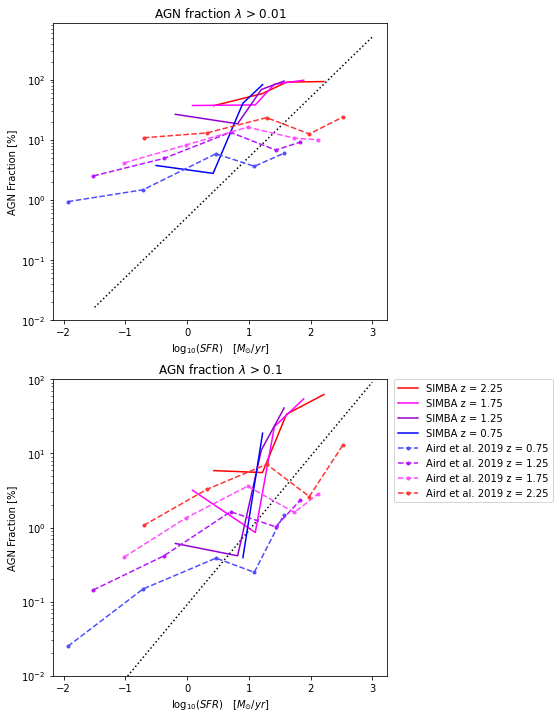

In [25]:
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.plot(SFR_bins_x, y2, ':', color='k')
ax1.plot(SFR_bins0[4],  AGN_fracs_gt20[4], linestyle='-', color=red,  label='SIMBA z = 2.25')
ax1.plot(SFR_bins0[3],  AGN_fracs_gt20[3], linestyle='-', color=pink, label='SIMBA z = 1.75')
ax1.plot(SFR_bins0[2],  AGN_fracs_gt20[2], linestyle='-', color=purple,  label='SIMBA z = 1.25')
ax1.plot(SFR_bins0[1],  AGN_fracs_gt20[1], linestyle='-', color=blue,  label=' SIMBA z = 0.75')




ax1.plot(jSFR_bins[1],  jAGN_fracs_gt2[1], linestyle='--', color=scale_lightness(blue, 1.3), marker='.', label='Aird et al. 2019 z = 0.75')
ax1.plot(jSFR_bins[2],  jAGN_fracs_gt2[2], linestyle='--', color=scale_lightness(purple, 1.3), marker='.', label='Aird et al. 2019 z = 1.25')
ax1.plot(jSFR_bins[3],  jAGN_fracs_gt2[3], linestyle='--', color=scale_lightness(pink, 1.3), marker='.', label='Aird et al. 2019 z = 1.75')
ax1.plot(jSFR_bins[4],  jAGN_fracs_gt2[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax1.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $\lambda$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

ax2.plot(SFR_bins_x, y1, ':', color='k')
ax2.plot(SFR_bins0[4],  AGN_fracs_gt10[4], linestyle='-', color=red, label='SIMBA z = 2.25')
ax2.plot(SFR_bins0[3],  AGN_fracs_gt10[3], linestyle='-', color=pink, label='SIMBA z = 1.75')
ax2.plot(SFR_bins0[2],  AGN_fracs_gt10[2], linestyle='-', color=purple, label='SIMBA z = 1.25')
ax2.plot(SFR_bins0[1],  AGN_fracs_gt10[1], linestyle='-', color=blue,  label='SIMBA z = 0.75')




ax2.plot(jSFR_bins[1],  jAGN_fracs_gt1[1], linestyle='--', color=scale_lightness(blue, 1.3),  marker='.', label='Aird et al. 2019 z = 0.75')
ax2.plot(jSFR_bins[2],  jAGN_fracs_gt1[2], linestyle='--', color=scale_lightness(purple, 1.3),  marker='.', label='Aird et al. 2019 z = 1.25')
ax2.plot(jSFR_bins[3],  jAGN_fracs_gt1[3], linestyle='--', color=scale_lightness(pink, 1.3),  marker='.', label='Aird et al. 2019 z = 1.75')
ax2.plot(jSFR_bins[4],  jAGN_fracs_gt1[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax2.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $\lambda$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

In [26]:
AGN_fracs_gt2, AGN_fracs_gt1, SFR_bins = agn_fracs(0.263)
AGN_fracs_gt20, AGN_fracs_gt10, SFR_bins0 = agn_fracs(0)

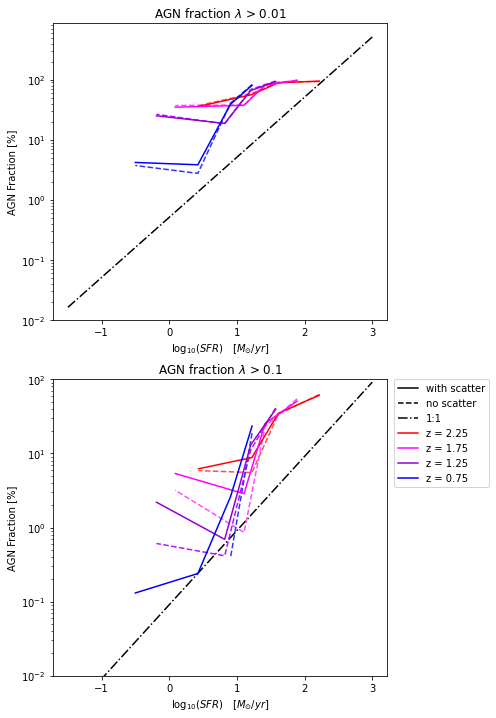

In [27]:
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.plot(SFR_bins_x, y2, '-.', color='k')
ax1.plot(SFR_bins0[4],  AGN_fracs_gt20[4], linestyle='--', color=scale_lightness(red, 1.3))
ax1.plot(SFR_bins0[3],  AGN_fracs_gt20[3], linestyle='--', color=scale_lightness(pink, 1.3))
ax1.plot(SFR_bins0[2],  AGN_fracs_gt20[2], linestyle='--', color=scale_lightness(purple, 1.3))
ax1.plot(SFR_bins0[1],  AGN_fracs_gt20[1], linestyle='--', color=scale_lightness(blue, 1.2))

ax1.plot(SFR_bins[4],  AGN_fracs_gt2[4], linestyle='-', color=red)
ax1.plot(SFR_bins[3],  AGN_fracs_gt2[3], linestyle='-', color=pink)
ax1.plot(SFR_bins[2],  AGN_fracs_gt2[2], linestyle='-', color=purple)
ax1.plot(SFR_bins[1],  AGN_fracs_gt2[1], linestyle='-', color=blue)


#ax1.plot(jSFR_bins[1],  jAGN_fracs_gt2[1], linestyle='--', color=scale_lightness(blue, 1.3), marker='.', label='Aird et al. 2019 z = 0.75')
#ax1.plot(jSFR_bins[2],  jAGN_fracs_gt2[2], linestyle='--', color=scale_lightness(purple, 1.3), marker='.', label='Aird et al. 2019 z = 1.25')
#ax1.plot(jSFR_bins[3],  jAGN_fracs_gt2[3], linestyle='--', color=scale_lightness(pink, 1.3), marker='.', label='Aird et al. 2019 z = 1.75')
#ax1.plot(jSFR_bins[4],  jAGN_fracs_gt2[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax1.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $\lambda$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

ax2.plot(SFR_bins_x, y1, '-.', color='k')
ax2.plot(SFR_bins0[4],  AGN_fracs_gt10[4], linestyle='--', color=scale_lightness(red, 1.3))
ax2.plot(SFR_bins0[3],  AGN_fracs_gt10[3], linestyle='--', color=scale_lightness(pink, 1.3))
ax2.plot(SFR_bins0[2],  AGN_fracs_gt10[2], linestyle='--', color=scale_lightness(purple, 1.3))
ax2.plot(SFR_bins0[1],  AGN_fracs_gt10[1], linestyle='--', color=scale_lightness(blue, 1.2))

ax2.plot(SFR_bins[4],  AGN_fracs_gt1[4], linestyle='-', color=red)
ax2.plot(SFR_bins[3],  AGN_fracs_gt1[3], linestyle='-', color=pink)
ax2.plot(SFR_bins[2],  AGN_fracs_gt1[2], linestyle='-', color=purple)
ax2.plot(SFR_bins[1],  AGN_fracs_gt1[1], linestyle='-', color=blue)

ax2.plot(0,0, linestyle='-', color='k', label='with scatter')
ax2.plot(0,0, linestyle='--', color='k', label='no scatter')
ax2.plot(0,0, linestyle='-.', color='k', label='1:1')
ax2.plot(0,0, linestyle='-', color=red, label='z = 2.25')
ax2.plot(0,0, linestyle='-', color=pink, label='z = 1.75')
ax2.plot(0,0, linestyle='-',  color=purple, label='z = 1.25')
ax2.plot(0,0, linestyle='-',  color=blue, label='z = 0.75')

#ax2.plot(jSFR_bins[1],  jAGN_fracs_gt1[1], linestyle='--', color=scale_lightness(blue, 1.3),  marker='.', label='Aird et al. 2019 z = 0.75')
#ax2.plot(jSFR_bins[2],  jAGN_fracs_gt1[2], linestyle='--', color=scale_lightness(purple, 1.3),  marker='.', label='Aird et al. 2019 z = 1.25')
#ax2.plot(jSFR_bins[3],  jAGN_fracs_gt1[3], linestyle='--', color=scale_lightness(pink, 1.3),  marker='.', label='Aird et al. 2019 z = 1.75')
#ax2.plot(jSFR_bins[4],  jAGN_fracs_gt1[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax2.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $\lambda$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

### How well lambda traces fedd

In [28]:
Ledd = all_r['z137']['Ledd'].data
fedd = all_r['z137']['fedd'].data
sfr = all_r['z137']['SFR'].data
BHAR = all_r['z137']['BHAR'].data
#logLedd = np.log10(Ledd[~np.isnan(Ledd)])

#ssfr = all_r['z137']['sSFR'][~np.isnan(Ledd)]
ssfr = all_r['z137']['sSFR']

delete_zeros = (~np.isnan(Ledd)) & (ssfr!=0)


#c = 0
#for i in range(len(ssfr)):
#    if ssfr[i] == 0:
#        c += 1
#        ssfr[i] = 1e-4
#print('the no of 0 ssfrs is:', c)
logssfr = np.log10(ssfr[delete_zeros])
logLedd = np.log10(Ledd[delete_zeros])
logfedd = np.log10(fedd[delete_zeros])
logsfr = np.log10(sfr[delete_zeros])
logBHAR = np.log10(BHAR[delete_zeros])

sm = all_r['z137']['sm'][delete_zeros]
logsm = np.log10(sm)

lmbda = all_r['z137']['lambda'][delete_zeros].data
loglmbda = np.log10(lmbda)

Lx = all_r['z137']['Lx'][delete_zeros]
logLx = np.log10(Lx)


bhm = all_r['z137']['bhm'][delete_zeros]
logbhm = np.log10(bhm)


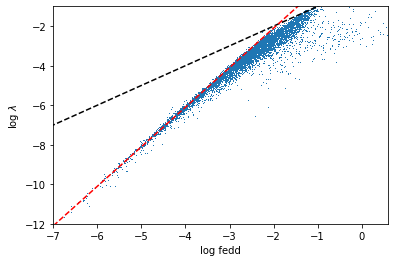

In [29]:
x = np.arange(-12, 1)
y = 2*x + 1.9
#y = -0.19*x**2 + 0.43*x -1.16
plt.plot(logfedd, loglmbda, ',')
plt.xlabel('log fedd')
plt.ylabel('log $\lambda$')
plt.plot(x, x, color='black', linestyle='--')
plt.plot(x, y, color='red', linestyle='--')
plt.xlim(-7, 0.6)
plt.ylim(-12, -1)
plt.show()

### Finding what determines the two populations

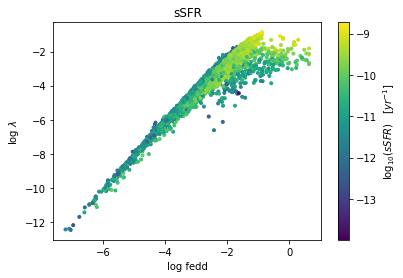

In [30]:
plt.scatter(logfedd, loglmbda, c=logssfr, marker='.')
plt.title('sSFR')
plt.xlabel('log fedd')
plt.ylabel('log $\lambda$')
plt.colorbar(label=r'$\log_{10}(sSFR) \quad [yr^{-1}]$')
plt.show()

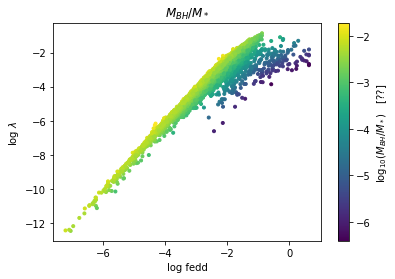

In [31]:
BHM = 10**logbhm
SM = 10**logsm
logbhm_sm = np.log10(BHM/SM)
plt.scatter(logfedd, loglmbda, c=logbhm_sm, marker='.')
plt.title('$M_{BH}/M_*$')
plt.xlabel('log fedd')
plt.ylabel('log $\lambda$')
plt.colorbar(label=r'$\log_{10}(M_{BH}/M_*) \quad [??]$')
plt.show()

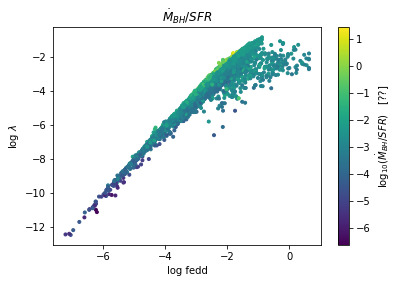

In [32]:
BHAR = 10**logBHAR
SFR = 10**logsfr
logBHAR_SFR = np.log10(BHAR/SFR)
plt.scatter(logfedd, loglmbda, c=logBHAR_SFR, marker='.')
plt.title('$\dot{M}_{BH}/SFR$')
plt.xlabel('log fedd')
plt.ylabel('log $\lambda$')
plt.colorbar(label=r'$\log_{10}(\dot{M}_{BH}/SFR) \quad [??]$')
plt.show()

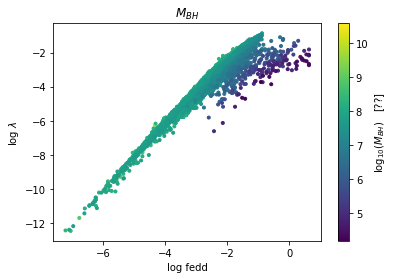

In [33]:
plt.scatter(logfedd, loglmbda, c=logbhm, marker='.')
plt.title('$M_{BH}$')
plt.xlabel('log fedd')
plt.ylabel('log $\lambda$')
plt.colorbar(label=r'$\log_{10}(M_{BH}) \quad [??]$')
plt.show()

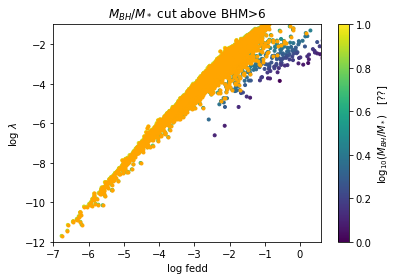

In [34]:
BHM = 10**logbhm
SM = 10**logsm
logbhm_sm = np.log10(BHM/SM)
y = 2*x + 1.9
plt.xlim(-7, 0.6)
plt.ylim(-12, -1)
plt.scatter(logfedd, loglmbda, c=logbhm_sm, marker='.')
plt.scatter(logfedd[logbhm>6], loglmbda[logbhm>6], marker='.', color='orange')
#plt.plot(x, y, color='red', linestyle='--')
plt.title('$M_{BH}/M_*$ cut above BHM>6')
plt.xlabel('log fedd')
plt.ylabel('log $\lambda$')
plt.colorbar(label=r'$\log_{10}(M_{BH}/M_*) \quad [??]$')
plt.show()

### Fitting line to small BH region

[ 1.01542898 -2.25534421]


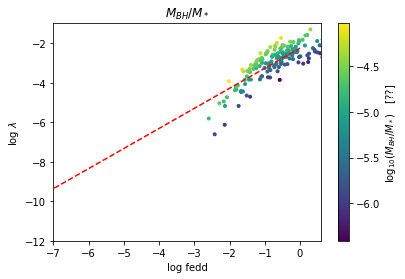

In [35]:
BHM = 10**logbhm[logbhm<6]
SM = 10**logsm[logbhm<6]
logbhm_sm = np.log10(BHM/SM)

p = np.polyfit(logfedd[logbhm<6], loglmbda[logbhm<6], 1)
y = p[0]*x + p[1]
print(p)

plt.xlim(-7, 0.6)
plt.ylim(-12, -1)
plt.scatter(logfedd[logbhm<6], loglmbda[logbhm<6], c=logbhm_sm, marker='.')
plt.plot(x, y, color='red', linestyle='--')
plt.title('$M_{BH}/M_*$')
plt.xlabel('log fedd')
plt.ylabel('log $\lambda$')
plt.colorbar(label=r'$\log_{10}(M_{BH}/M_*) \quad [??]$')
plt.show()

### Fitting lines to region where BHM > 6

/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


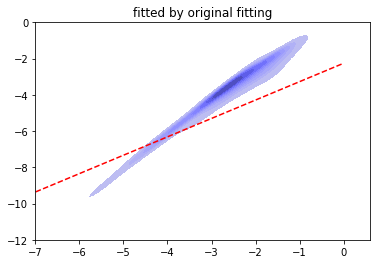

In [36]:
fig, (ax1) = plt.subplots(1, 1)
#ax1.scatter(logfedd[logbhm>7], loglmbda[logbhm>7], c=logbhm_sm, marker='.')
#ax1.plot(logfedd[logbhm>7], loglmbda[logbhm>7], '.')
#ax1.plot(x, y-10, color='red', linestyle='--')

sns.kdeplot(logfedd[logbhm>6], loglmbda[logbhm>6], color='b', ax = ax1, linewidth=0.1, fill=True)
plt.xlim(-7, 0.6)
plt.ylim(-12, 0)
plt.plot(x, y, color='red', linestyle='--')
plt.title('fitted by original fitting')
plt.show()

/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


Text(0.5, 1.0, 'badly trying to fit with density(by eye)')

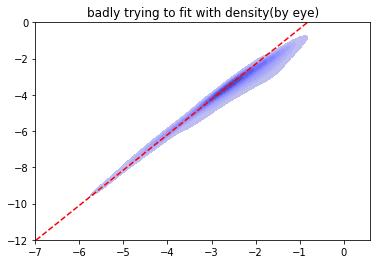

In [37]:
fig, (ax1) = plt.subplots(1, 1)
#ax1.scatter(logfedd[logbhm>7], loglmbda[logbhm>7], c=logbhm_sm, marker='.')
#ax1.plot(logfedd[logbhm>7], loglmbda[logbhm>7], '.')
#ax1.plot(x, y-10, color='red', linestyle='--')
y = 1.95*x + 1.6
sns.kdeplot(logfedd[logbhm>6], loglmbda[logbhm>6], color='b', ax = ax1, linewidth=0.1, fill=True)
plt.xlim(-7, 0.6)
plt.ylim(-12, 0)
plt.plot(x, y, color='red', linestyle='--')
plt.title('badly trying to fit with density(by eye)')

/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[1.70964163 0.70494248]


/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


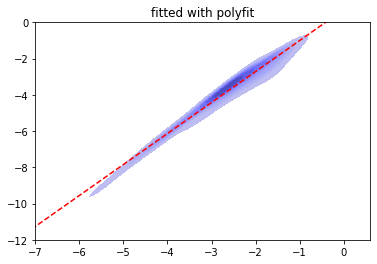

In [38]:
fig, (ax1) = plt.subplots(1, 1)
sns.kdeplot(logfedd[logbhm>6], loglmbda[logbhm>6], color='b', ax = ax1, linewidth=0.1, fill=True)
plt.xlim(-7, 0.6)
plt.ylim(-12, 0)
p = np.polyfit(logfedd[logbhm>6], loglmbda[logbhm>6], 1)
print(p)
yfit = p[0]*x + p[1]
plt.plot(x, yfit, color='red', linestyle='--')
plt.title('fitted with polyfit')
plt.show()

/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


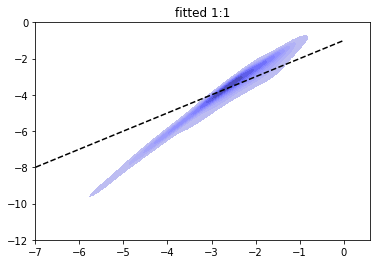

In [39]:
fig, (ax1) = plt.subplots(1, 1)
sns.kdeplot(logfedd[logbhm>6], loglmbda[logbhm>6], color='b', ax = ax1, linewidth=0.1, fill=True)
plt.xlim(-7, 0.6)
plt.ylim(-12, 0)
plt.plot(x, x-1, color='k', linestyle='--')
plt.title('fitted 1:1')
plt.show()

/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


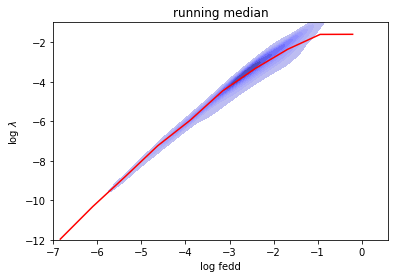

In [40]:
def avplot(ax,x,y, linecolor, nbins=10,xrange=None,linestyle='None', **kwargs):
    '''
    Plots average (mean) of y in bins of x
    Inputs:
    ax - matplotlib axis
    x, y - co-ordinates
    Optional inputs:
    nbins (default=10): number of evenly spaced bins in x to use
    xrange: defaults to min-to-max of x
    linestyle: line to plot (default is none)
    **kwargs: keywords to pass to plot routine.
    '''
    if xrange is None:
        xrange=[np.min(x),np.max(x)]
    t,l=np.histogram(x,weights=y,range=xrange,bins=nbins)
    n,l=np.histogram(x,range=xrange,bins=nbins)
    ax.plot( (l[1:]+l[0:-1])/2.0,t*1.0/n, color=linecolor)

fig1, ax1 = plt.subplots()

sns.kdeplot(logfedd[logbhm>6], loglmbda[logbhm>6], color='b', ax = ax1, linewidth=0.1, fill=True)
avplot(ax1, logfedd[logbhm>6],  loglmbda[logbhm>6],'red')
plt.xlabel('log fedd')
plt.ylabel('log $\lambda$')
plt.xlim(-7, 0.6)
plt.ylim(-12, -1)
plt.title('running median')
plt.show()

### Checking bhm to sm relation to see if sf galaxies overestimate bhm

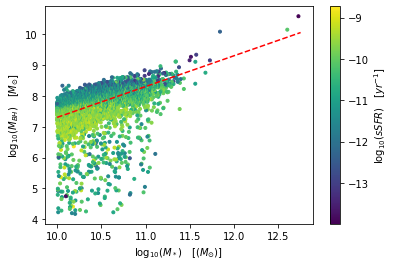

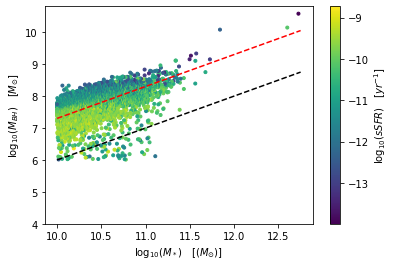

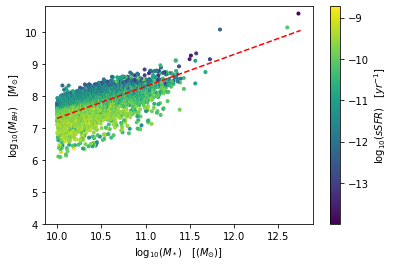

In [41]:
plt.scatter(logsm, logbhm, c=logssfr, marker='.')

x = np.linspace(10, 12.75, 20)
y = np.log10(0.002) + x

plt.plot(x, y, color='red', linestyle='--')
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(M_{BH}) \quad [M_{\odot}]$')
plt.colorbar(label=r'$\log_{10}(sSFR) \quad [yr^{-1}]$')
plt.show()

plt.scatter(logsm[logbhm>6], logbhm[logbhm>6], c=logssfr[logbhm>6], marker='.')
ycut = x - 4

plt.plot(x, y, color='red', linestyle='--')
plt.plot(x, ycut, color='k', linestyle='--')
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(M_{BH}) \quad [M_{\odot}]$')
plt.colorbar(label=r'$\log_{10}(sSFR) \quad [yr^{-1}]$')
plt.ylim(bottom=4)
plt.show()

plt.scatter(logsm[logbhm>(logsm - 4)], logbhm[logbhm>(logsm - 4)], c=logssfr[logbhm>(logsm - 4)], marker='.')

plt.plot(x, y, color='red', linestyle='--')
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(M_{BH}) \quad [M_{\odot}]$')
plt.colorbar(label=r'$\log_{10}(sSFR) \quad [yr^{-1}]$')
plt.ylim(bottom=4)
plt.show()

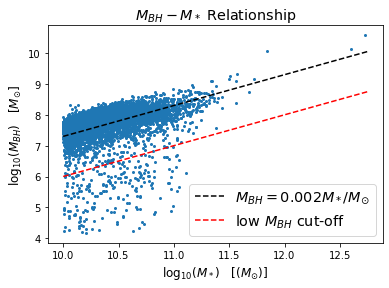

In [42]:
plt.plot(logsm, logbhm, '.', markersize=4)

x = np.linspace(10, 12.75, 20)
y = np.log10(0.002) + x
ycut = x - 4

plt.plot(x, y, color='k', linestyle='--', label='$M_{BH} = 0.002 M_* / M_{\odot}$')
plt.plot(x, ycut, color='red', linestyle='--', label='low $M_{BH}$ cut-off')
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$', fontsize='large')
plt.ylabel('$\log_{10}(M_{BH}) \quad [M_{\odot}]$', fontsize='large')
plt.legend(loc='lower right', fontsize='x-large')
plt.title('$M_{BH} - M_*$ Relationship', fontsize='x-large')
plt.show()

/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/sarah/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


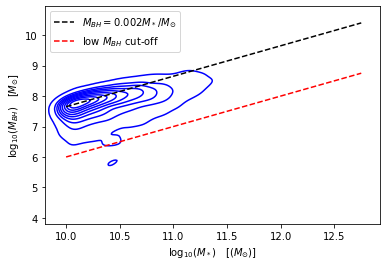

In [43]:
fig1, ax1 = plt.subplots()
sns.kdeplot(logsm, logbhm, color='b', ax = ax1, linewidth=0.1)

x = np.linspace(10, 12.75, 20)
y = np.log10(0.002) + x + 0.35
ycut = x - 4

plt.plot(x, y, color='k', linestyle='--', label='$M_{BH} = 0.002 M_* / M_{\odot}$')
plt.plot(x, ycut, color='red', linestyle='--', label='low $M_{BH}$ cut-off')
plt.xlabel('$\log_{10}(M_*) \quad [(M_{\odot})]$')
plt.ylabel('$\log_{10}(M_{BH}) \quad [M_{\odot}]$')
plt.legend()
plt.show()

#### Adding this cut to log lambda - fedd plots

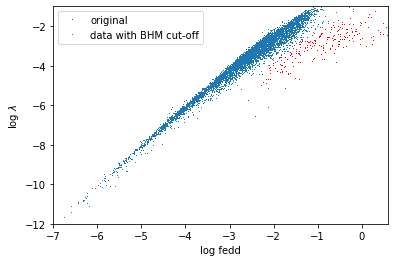

In [44]:
plt.plot(logfedd, loglmbda, 'r,', label='original')
plt.plot(logfedd[logbhm>(logsm - 4)], loglmbda[logbhm>(logsm - 4)], ',', label='data with BHM cut-off')
plt.xlabel('log fedd')
plt.ylabel('log $\lambda$')
plt.xlim(-7, 0.6)
plt.ylim(-12, -1)
plt.legend()
plt.show()

[1.73104382 0.7756637 ]


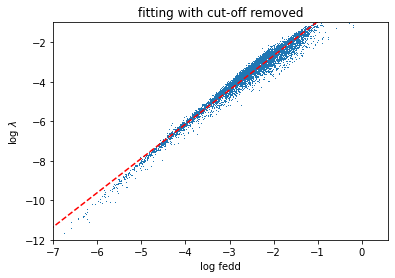

In [45]:
x = np.arange(-12, 1)
plt.plot(logfedd[logbhm>(logsm - 4)], loglmbda[logbhm>(logsm - 4)], ',')

p = np.polyfit(logfedd[logbhm>(logsm - 4)], loglmbda[logbhm>(logsm - 4)], 1)
print(p)
yfit = p[0]*x + p[1]
plt.plot(x, yfit, color='red', linestyle='--')

plt.xlabel('log fedd')
plt.ylabel('log $\lambda$')
plt.xlim(-7, 0.6)
plt.ylim(-12, -1)
plt.title('fitting with cut-off removed')
plt.show()

[ 0.97488029 -2.17040425]


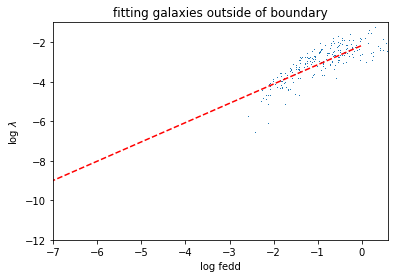

In [46]:
x = np.arange(-12, 1)
plt.plot(logfedd[logbhm<(logsm - 4)], loglmbda[logbhm<(logsm - 4)], ',')

p = np.polyfit(logfedd[logbhm<(logsm - 4)], loglmbda[logbhm<(logsm - 4)], 1)
print(p)
yfit = p[0]*x + p[1]
plt.plot(x, yfit, color='red', linestyle='--')

plt.xlabel('log fedd')
plt.ylabel('log $\lambda$')
plt.xlim(-7, 0.6)
plt.ylim(-12, -1)
plt.title('fitting galaxies outside of boundary')
plt.show()

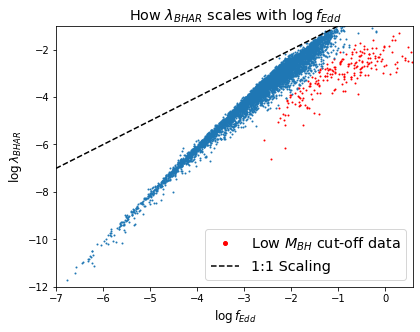

In [47]:
x = np.arange(-12, 1)
plt.rcParams['figure.figsize'] = (6.4,4.8)
plt.plot(logfedd[logbhm<(logsm - 4)], loglmbda[logbhm<(logsm - 4)], 'r.', markersize=2, label='Low $M_{BH}$ cut-off data')
plt.plot(logfedd[logbhm>(logsm - 4)], loglmbda[logbhm>(logsm - 4)], '.', markersize=2)
plt.plot(x, x, '--', color='k', label='1:1 Scaling')
plt.xlabel('$\logf_{Edd}$', fontsize='large')
plt.ylabel('$\log \lambda_{BHAR}$', fontsize='large')
plt.xlim(-7, 0.6)
plt.ylim(-12, -1)
plt.legend(loc='lower right', fontsize='x-large', markerscale=4)
plt.title('How $\lambda_{BHAR}$ scales with $\logf_{Edd}$', fontsize='x-large')
plt.show()

plotting Mdotbhm against Lx

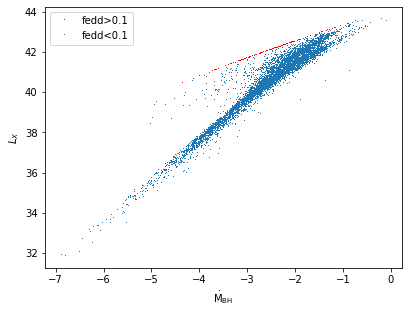

In [48]:
plt.plot(logBHAR[logfedd>-1], logLx[logfedd>-1], 'r,', label='fedd>0.1')
plt.plot(logBHAR[logfedd<-1], logLx[logfedd<-1], ',', label='fedd<0.1')
plt.xlabel('$\dot{\mathrm{M}}_{\mathrm{BH}}$')
plt.ylabel('$L_X$')
plt.legend()
plt.show()

[ 1.87285238 45.29153579]


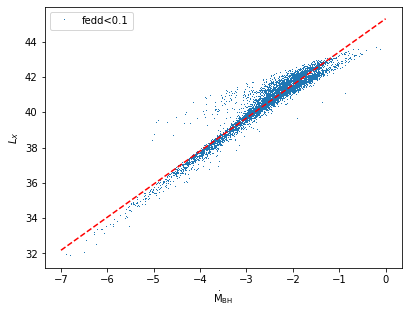

In [49]:
p = np.polyfit(logBHAR[logfedd<-1], logLx[logfedd<-1], 1)
print(p)
x = np.linspace(-7, 0, 20)
yfit = p[0]*x + p[1]

plt.plot(logBHAR[logfedd<-1], logLx[logfedd<-1], ',', label='fedd<0.1')
plt.plot(x, yfit, color='red', linestyle='--')
#plt.plot(x, (1.73*x + 44.7), color='k', linestyle='--')
plt.xlabel('$\dot{\mathrm{M}}_{\mathrm{BH}}$')
plt.ylabel('$L_X$')
plt.legend()
plt.show()

[ 1.85850542 45.28645686]


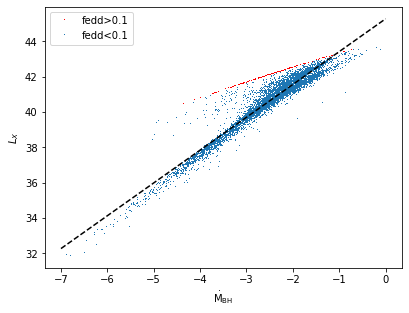

In [50]:
p = np.polyfit(logBHAR, logLx, 1)
print(p)
x = np.linspace(-7, 0, 20)
yfit = p[0]*x + p[1]
plt.plot(logBHAR[logfedd>-1], logLx[logfedd>-1], 'r,', label='fedd>0.1')
plt.plot(logBHAR[logfedd<-1], logLx[logfedd<-1], ',', label='fedd<0.1')
plt.plot(x, yfit, color='k', linestyle='--')
plt.xlabel('$\dot{\mathrm{M}}_{\mathrm{BH}}$')
plt.ylabel('$L_X$')
plt.legend()
plt.show()

[ 0.1841521  -1.21513658]


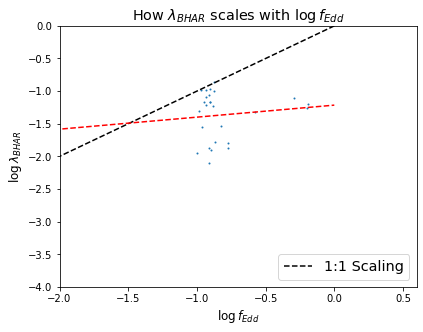

In [51]:
mask = (logbhm>(logsm - 4)) & (logfedd>-1)
x = np.arange(-12, 1)
p = np.polyfit(logfedd[mask], loglmbda[mask], 1)
print(p)
#x = np.linspace(-7, 0, 20)
yfit = p[0]*x + p[1]
plt.plot(logfedd[mask], loglmbda[mask], '.', markersize=2)
plt.plot(x, x, '--', color='k', label='1:1 Scaling')
plt.plot(x, yfit, '--', color='red')
plt.xlabel('$\logf_{Edd}$', fontsize='large')
plt.ylabel('$\log \lambda_{BHAR}$', fontsize='large')
plt.xlim(-2, 0.6)
plt.ylim(-4, 0)
plt.legend(loc='lower right', fontsize='x-large', markerscale=4)
plt.title('How $\lambda_{BHAR}$ scales with $\logf_{Edd}$', fontsize='x-large')
plt.show()

[ 0.93513704 72.31617116]


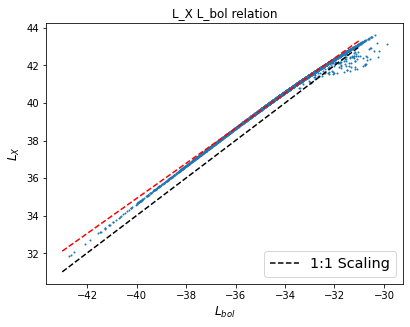

In [52]:
logLbol = 2*logBHAR + 2*np.log10(3E8) - np.log10(1.3E38) -logbhm

x = np.arange(-43, -30)
p = np.polyfit(logLbol, logLx, 1)
print(p)
#x = np.linspace(-7, 0, 20)
yfit = p[0]*x + p[1]
plt.plot(logLbol, logLx, '.', markersize=2)
plt.plot(x, x+74, '--', color='k', label='1:1 Scaling')
plt.plot(x, yfit, '--', color='red')
plt.xlabel('$L_{bol}$', fontsize='large')
plt.ylabel('$L_X$', fontsize='large')
#plt.xlim(-2, 0.6)
#plt.ylim(-4, 0)
plt.legend(loc='lower right', fontsize='x-large', markerscale=4)
plt.title('L_X L_bol relation')
plt.show()

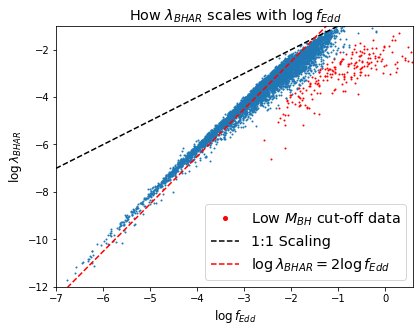

In [53]:
x = np.arange(-12, 1)
plt.rcParams['figure.figsize'] = (6.4,4.8)
plt.plot(logfedd[logbhm<(logsm - 4)], loglmbda[logbhm<(logsm - 4)], 'r.', markersize=2, label='Low $M_{BH}$ cut-off data')
plt.plot(logfedd[logbhm>(logsm - 4)], loglmbda[logbhm>(logsm - 4)], '.', markersize=2)
plt.plot(x, x, '--', color='k', label='1:1 Scaling')
plt.plot(x, 2*x + 1.5, '--', color='r', label='$\log \lambda_{BHAR} = 2 \logf_{Edd}$')
plt.xlabel('$\logf_{Edd}$', fontsize='large')
plt.ylabel('$\log \lambda_{BHAR}$', fontsize='large')
plt.xlim(-7, 0.6)
plt.ylim(-12, -1)
plt.legend(loc='lower right', fontsize='x-large', markerscale=4)
plt.title('How $\lambda_{BHAR}$ scales with $\logf_{Edd}$', fontsize='x-large')
plt.show()

## Looking at distribution of fedd in simba directly

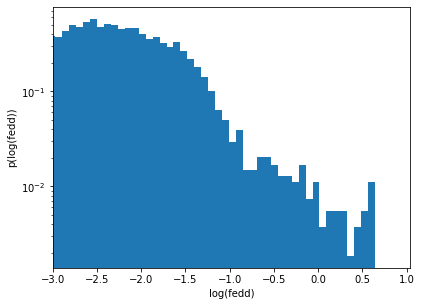

In [65]:
plt.hist(logfedd, bins=100,density=True)
#plt.xlim(left=34)
plt.xlabel('log(fedd)')
plt.ylabel('p(log(fedd))')
plt.xlim(left=-3)
plt.yscale('log')
plt.show()

In [63]:
fraction_gt2 = np.size(logfedd[logfedd>-2])/np.size(logfedd)
print(fraction_gt2)
fraction_gt1 = np.size(logfedd[logfedd>-1])/np.size(logfedd)
print(fraction_gt1)

0.2540005819028222
0.02109397730578993


In [85]:
all_r = get_all_r();

yt : [INFO     ] 2023-03-04 15:23:18,238 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_137.hdf5
yt : [INFO     ] 2023-03-04 15:23:18,283 Found 482650 halos
yt : [INFO     ] 2023-03-04 15:23:18,295 Found 49752 galaxies
/tmp/ipykernel_339961/4053297392.py:37: RuntimeWarning: invalid value encountered in true_divide
  Ledd = bhmdot/bh_fedd
/home/sarah/anaconda3/lib/python3.9/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/tmp/ipykernel_339961/4053297392.py:54: RuntimeWarning: divide by zero encountered in log10
  Lx_ergs = ((10**(np.log10(Lbol.to('L_sun').value)-np.log10(BC)))*u.L_sun).to('erg/s')
yt : [INFO     ] 2023-03-04 15:23:20,144 Opening /disk04/rad/sim/m100n1024/s50/Groups/m100n1024_114.hdf5
yt : [INFO     ] 2023-03-04 15:23:20,174 Found 517907 halos
yt : [INFO     ] 2023-03-04 15:23:20,183 Found 41585 galaxies
yt : [INFO     ] 2023-03-04 15:23:23,247

In [82]:
def fedd_find_fracs(fedd):
    '''
    Finds the percentage of galaxies with lambda greater than 0.01 and 0.1 AND Lx greater than 10^42 for a given set 
    of galaxies defined by their input log lambdas.
    
    Parameters:
                lambdas : array_like
                          An array of log(lambdas)
                      

        Returns:
                frac_gt2 : float
                           The percentage of galaxies with lambda greater than 0.01 AND Lx greater than 10^42
                frac_gt1 : float
                           The percentage of galaxies with lambda greater than 0.1 AND Lx greater than 10^42
                           
    
    '''
    mask2 = (fedd> -2)
    l_gr2 = fedd[mask2]
            
    if len(l_gr2) == 0:
        print('there are no fedd>0.01')
        frac_gt2 = float('NaN')
    else:
        frac_gt2 = (len(l_gr2)/len(fedd))*100

    mask1 = (fedd > -1)
    l_gr1 = fedd[mask1]

    if len(l_gr1) == 0:
        print('there are no fedd>0.1')
        frac_gt1 = float('Nan')
    else:
        frac_gt1 = (len(l_gr1)/len(fedd))*100

    print(frac_gt2)
    print(frac_gt1)
    
    return frac_gt2, frac_gt1

In [89]:
def fedd_agn_fracs(sigma):
    
        #all_r = get_all_r()
        z = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5]

        # lists to store the 6 agn fractions (each redshift)
        AGN_fracs_gt2 = []
        AGN_fracs_gt1 = []

        # list to store the 6 sfr bin midpoints for plotting
        SFR_bins = []

        #iterating across each redshift
        for count, key in enumerate(all_r):

            #
            AGN_frac_per_bin_gt2 = np.array([])
            AGN_frac_per_bin_gt1 = np.array([])

            #extract xray luminosities to make mask Lx> 10^42
            Lx = all_r[key]['Lx'].copy()
            #fedd = all_r[key]['fedd'].copy()

            no_zeros = (Lx!=0)
            #no_zeros = (fedd!=0)

            #Lx = Lx[no_zeros]
            #fedd = fedd[no_zeros]

            sm = all_r[key]['sm'][no_zeros].copy()
            logsm = np.log10(sm.data)

            # NEW WAY: binning the mass data
            #extracting the sfrs for this redshift
            SFRs_all = all_r[key]['SFR'][no_zeros].copy()
            SFRs = SFRs_all

            #creating an empty array with the size equal to the amount of 0 sfr values
            rand_sams = np.zeros(SFRs[SFRs == 0].shape)

            #filling the empty array with random numbers ranging between 0.000001 and 0.00001
            for i in range(len(rand_sams)):
                rand_sams[i] = np.random.uniform(1e-3, 1e-2)

            #replacing 0 sfr values with the randomly sampled low values
            SFRs[SFRs == 0] = rand_sams

            #logging the full sfr array with 0 values replaced
            logSFRs = np.log10(np.asarray(SFRs))

            #calculating relative MS values
            logSFR_MS = logSFRs + 7.6 - 0.76*logsm - 2.95*np.log10(1+z[count])

            #defining bin boundaries
            bins = [np.inf, 0.15, -0.4, -0.95, -np.inf]

            #binning data based on relative MS values
            digitized = np.digitize(logSFR_MS, bins)

            # finding plotting points
            SFRs_midpoints = np.array([])

            # iterating across each bin
            for i in range(1, len(bins)):
                # finding the lambdas in a certain bin
                fedd = all_r[key]['fedd'][no_zeros].copy()
                logfedd = np.log10(fedd[digitized == i])
                
                #plt.hist(logfedd, bins=100,density=True)
                #plt.xlabel('log(fedd)')
                #plt.ylabel('p(log(fedd))')
                #plt.xlim(left=-3)
                #plt.yscale('log')
                #plt.show()

                #plt.hist(lambdas, bins=100)
                #plt.show()


                '''        
                #NOT ADDING SCATTER
                '''
                #mu = np.mean(fedd)
                
                #np.random.seed(999)
                #new_fedds = fedd + np.random.normal(0, sigma, fedd.size)
               


                # finding the Lxs in a certain bin
                #Lx_binned = Lx[digitized == i]
                # finding the agn fractions (2) for a certain bin
                frac_gt2, frac_gt1 = fedd_find_fracs(logfedd)

                #binning sfrs
                sfr_binned = logSFRs[digitized == i]
                SFRs_midpoints = np.append(SFRs_midpoints, np.median(sfr_binned))

                #adding the agn fraction of each bin to an array length 5 (no of bins)
                AGN_frac_per_bin_gt2 = np.append(AGN_frac_per_bin_gt2, frac_gt2)
                AGN_frac_per_bin_gt1 = np.append(AGN_frac_per_bin_gt1, frac_gt1)



            SFR_bins.append(SFRs_midpoints)
            # adding the certain redshifts agn fraction for each bin, into an array length 6 (no of redshifts)
            AGN_fracs_gt2.append(AGN_frac_per_bin_gt2)
            AGN_fracs_gt1.append(AGN_frac_per_bin_gt1)
            
            #this might not work becayse the redshift lists are different lengths
            #fracs2 = np.array(AGN_fracs_gt2)
            #fracs1 = np.array(AGN_fracs_gt1)
            
            #variations = fracs1/fracs2
            #print(variations)
            
        return AGN_fracs_gt2, AGN_fracs_gt1, SFR_bins

In [90]:
AGN_fracs_gt2, AGN_fracs_gt1, SFR_bins = fedd_agn_fracs(0.263)

85.68738229755178
4.048964218455744
36.4201796821009
3.455425017277125
6.686701728024041
1.5026296018031555
7.794618001855862
0.9897927621404269
98.89737065309583
34.01187446988973
81.93421698576337
3.1418753068237604
19.06474820143885
3.7170263788968825
13.49492302653128
0.8843760235833606
99.43019943019942
71.08262108262107
94.51754385964912
18.464912280701753
53.95284327323162
4.854368932038835
44.905430140329464
1.8913971934106162
99.33993399339934
92.07920792079209
97.20238095238095
41.25
78.6838340486409
4.57796852646638
55.7163531114327
4.486251808972503
96.2406015037594
92.4812030075188
98.47533632286995
64.03587443946188
89.82758620689654
12.586206896551724
51.03448275862069
9.655172413793103
100.0
96.96969696969697
98.53747714808044
72.94332723948813
96.32867132867133
27.797202797202797
63.33333333333333
5.0
100.0
85.71428571428571
99.00497512437812
87.06467661691542
98.01136363636364
52.55681818181818
84.61538461538461
19.230769230769234


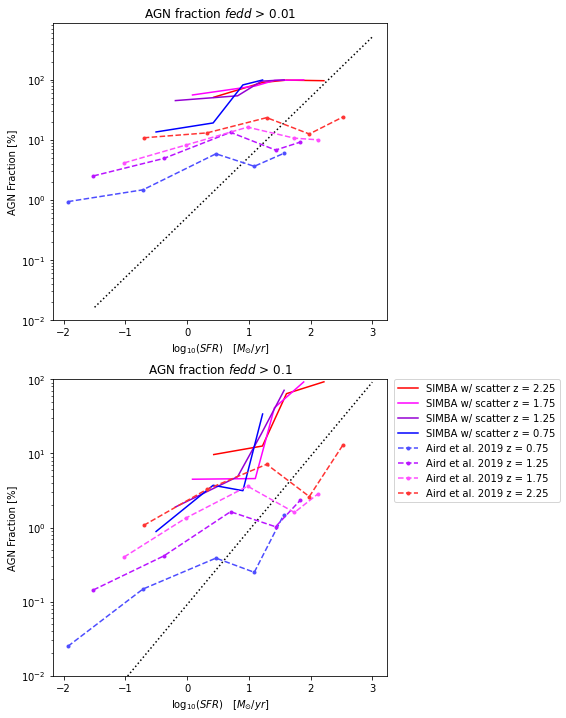

In [92]:
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.plot(SFR_bins_x, y2, ':', color='k')
ax1.plot(SFR_bins[4],  AGN_fracs_gt2[4], linestyle='-', color=red,  label='SIMBA w/ scatter z = 2.25')
ax1.plot(SFR_bins[3],  AGN_fracs_gt2[3], linestyle='-', color=pink, label='SIMBA w/ scatter z = 1.75')
ax1.plot(SFR_bins[2],  AGN_fracs_gt2[2], linestyle='-', color=purple,  label='SIMBA w/ scatter z = 1.25')
ax1.plot(SFR_bins[1],  AGN_fracs_gt2[1], linestyle='-', color=blue,  label=' SIMBA w/ scatter z = 0.75')




ax1.plot(jSFR_bins[1],  jAGN_fracs_gt2[1], linestyle='--', color=scale_lightness(blue, 1.3), marker='.', label='Aird et al. 2019 z = 0.75')
ax1.plot(jSFR_bins[2],  jAGN_fracs_gt2[2], linestyle='--', color=scale_lightness(purple, 1.3), marker='.', label='Aird et al. 2019 z = 1.25')
ax1.plot(jSFR_bins[3],  jAGN_fracs_gt2[3], linestyle='--', color=scale_lightness(pink, 1.3), marker='.', label='Aird et al. 2019 z = 1.75')
ax1.plot(jSFR_bins[4],  jAGN_fracs_gt2[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax1.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $fedd$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

ax2.plot(SFR_bins_x, y1, ':', color='k')
ax2.plot(SFR_bins[4],  AGN_fracs_gt1[4], linestyle='-', color=red, label='SIMBA w/ scatter z = 2.25')
ax2.plot(SFR_bins[3],  AGN_fracs_gt1[3], linestyle='-', color=pink, label='SIMBA w/ scatter z = 1.75')
ax2.plot(SFR_bins[2],  AGN_fracs_gt1[2], linestyle='-', color=purple, label='SIMBA w/ scatter z = 1.25')
ax2.plot(SFR_bins[1],  AGN_fracs_gt1[1], linestyle='-', color=blue,  label='SIMBA w/ scatter z = 0.75')




ax2.plot(jSFR_bins[1],  jAGN_fracs_gt1[1], linestyle='--', color=scale_lightness(blue, 1.3),  marker='.', label='Aird et al. 2019 z = 0.75')
ax2.plot(jSFR_bins[2],  jAGN_fracs_gt1[2], linestyle='--', color=scale_lightness(purple, 1.3),  marker='.', label='Aird et al. 2019 z = 1.25')
ax2.plot(jSFR_bins[3],  jAGN_fracs_gt1[3], linestyle='--', color=scale_lightness(pink, 1.3),  marker='.', label='Aird et al. 2019 z = 1.75')
ax2.plot(jSFR_bins[4],  jAGN_fracs_gt1[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax2.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $fedd$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()

# Ajusting for fedd squared by changing thresholds to $\lambda > 0.0001$ and $\lambda > 0.001$


In [54]:
def new_find_fracs(lambdas, Lx):
    '''
    Finds the percentage of galaxies with lambda greater than 0.01 and 0.1 AND Lx greater than 10^42 for a given set 
    of galaxies defined by their input log lambdas.
    
    Parameters:
                lambdas : array_like
                          An array of log(lambdas)
                      

        Returns:
                frac_gt2 : float
                           The percentage of galaxies with lambda greater than 0.01 AND Lx greater than 10^42
                frac_gt1 : float
                           The percentage of galaxies with lambda greater than 0.1 AND Lx greater than 10^42
                           
    
    '''
    mask2 = (lambdas > -4) & (Lx > 1e42)
    l_gr2 = lambdas[mask2]
            
    if len(l_gr2) == 0:
        #print('there are no lambdas>0.01')
        frac_gt2 = float('NaN')
    else:
        frac_gt2 = (len(l_gr2)/len(lambdas))*100

    mask1 = (lambdas > -2) & (Lx > 1e42)
    l_gr1 = lambdas[mask1]

    if len(l_gr1) == 0:
        #print('there are no lambdas>0.1')
        frac_gt1 = float('Nan')
    else:
        frac_gt1 = (len(l_gr1)/len(lambdas))*100

    #print(frac_gt2)
    #print(frac_gt1)
    
    return frac_gt2, frac_gt1

In [55]:
def new_agn_fracs(sigma):
    
        #all_r = get_all_r()
        z = [0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.5]

        # lists to store the 6 agn fractions (each redshift)
        AGN_fracs_gt2 = []
        AGN_fracs_gt1 = []

        # list to store the 6 sfr bin midpoints for plotting
        SFR_bins = []

        #iterating across each redshift
        for count, key in enumerate(all_r):

            #
            AGN_frac_per_bin_gt2 = np.array([])
            AGN_frac_per_bin_gt1 = np.array([])

            #extract xray luminosities to make mask Lx> 10^42
            Lx = all_r[key]['Lx'].copy()

            no_zeros = (Lx!=0)

            Lx = Lx[no_zeros]

            sm = all_r[key]['sm'][no_zeros].copy()
            logsm = np.log10(sm.data)

            # NEW WAY: binning the mass data
            #extracting the sfrs for this redshift
            SFRs_all = all_r[key]['SFR'][no_zeros].copy()
            SFRs = SFRs_all

            #creating an empty array with the size equal to the amount of 0 sfr values
            rand_sams = np.zeros(SFRs[SFRs == 0].shape)

            #filling the empty array with random numbers ranging between 0.000001 and 0.00001
            for i in range(len(rand_sams)):
                rand_sams[i] = np.random.uniform(1e-3, 1e-2)

            #replacing 0 sfr values with the randomly sampled low values
            SFRs[SFRs == 0] = rand_sams

            #logging the full sfr array with 0 values replaced
            logSFRs = np.log10(np.asarray(SFRs))

            #calculating relative MS values
            logSFR_MS = logSFRs + 7.6 - 0.76*logsm - 2.95*np.log10(1+z[count])

            #defining bin boundaries
            bins = [np.inf, 0.15, -0.4, -0.95, -np.inf]

            #binning data based on relative MS values
            digitized = np.digitize(logSFR_MS, bins)

            # finding plotting points
            SFRs_midpoints = np.array([])

            # iterating across each bin
            for i in range(1, len(bins)):
                # finding the lambdas in a certain bin
                lmbda = all_r[key]['lambda'][no_zeros].copy()
                lambdas = np.log10(lmbda[digitized == i])

                #plt.hist(lambdas, bins=100)
                #plt.show()


                '''        
                #ADDING SCATTER
                '''
                mu = np.mean(lambdas)
                #sigma = sigma

                #print('loglams:', lambdas)
                #print('mean:', mu)
                #print('stdev:', sigma)

                #print(lambdas.size)
                np.random.seed(999)
                new_lambdas = lambdas + np.random.normal(0, sigma, lambdas.size)
                #new_lambdas = np.random.poisson(mu, lambdas.size)


                # finding the Lxs in a certain bin
                Lx_binned = Lx[digitized == i]
                # finding the agn fractions (2) for a certain bin
                frac_gt2, frac_gt1 = new_find_fracs(new_lambdas, Lx_binned)

                #binning sfrs
                sfr_binned = logSFRs[digitized == i]
                SFRs_midpoints = np.append(SFRs_midpoints, np.median(sfr_binned))

                #adding the agn fraction of each bin to an array length 5 (no of bins)
                AGN_frac_per_bin_gt2 = np.append(AGN_frac_per_bin_gt2, frac_gt2)
                AGN_frac_per_bin_gt1 = np.append(AGN_frac_per_bin_gt1, frac_gt1)



            SFR_bins.append(SFRs_midpoints)
            # adding the certain redshifts agn fraction for each bin, into an array length 6 (no of redshifts)
            AGN_fracs_gt2.append(AGN_frac_per_bin_gt2)
            AGN_fracs_gt1.append(AGN_frac_per_bin_gt1)
            
            #this might not work becayse the redshift lists are different lengths
            #fracs2 = np.array(AGN_fracs_gt2)
            #fracs1 = np.array(AGN_fracs_gt1)
            
            #variations = fracs1/fracs2
            #print(variations)
            
        return AGN_fracs_gt2, AGN_fracs_gt1, SFR_bins

In [56]:
AGN_fracs_gt2, AGN_fracs_gt1, SFR_bins = new_agn_fracs(0.263)

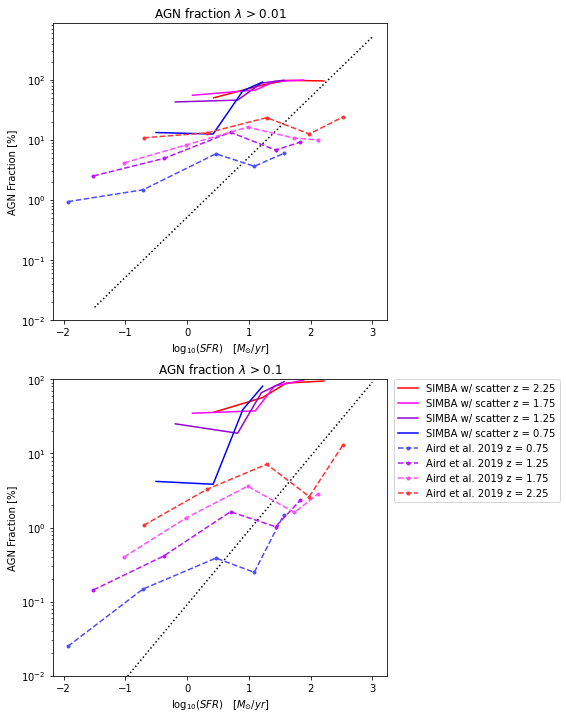

In [57]:
SFR_bins_x = np.array([-1.5, -0.75, -0.25, 0.25, 0.75, 1.25, 3])

# equations 5 and 6 line
logy2 = -0.59 + SFR_bins_x
y2 = (10**logy2)*2
#print(y2)
logy1 = -1.34 + SFR_bins_x
y1 = (10**logy1)*2
#print(y1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 12))

ax1.plot(SFR_bins_x, y2, ':', color='k')
ax1.plot(SFR_bins[4],  AGN_fracs_gt2[4], linestyle='-', color=red,  label='SIMBA w/ scatter z = 2.25')
ax1.plot(SFR_bins[3],  AGN_fracs_gt2[3], linestyle='-', color=pink, label='SIMBA w/ scatter z = 1.75')
ax1.plot(SFR_bins[2],  AGN_fracs_gt2[2], linestyle='-', color=purple,  label='SIMBA w/ scatter z = 1.25')
ax1.plot(SFR_bins[1],  AGN_fracs_gt2[1], linestyle='-', color=blue,  label=' SIMBA w/ scatter z = 0.75')




ax1.plot(jSFR_bins[1],  jAGN_fracs_gt2[1], linestyle='--', color=scale_lightness(blue, 1.3), marker='.', label='Aird et al. 2019 z = 0.75')
ax1.plot(jSFR_bins[2],  jAGN_fracs_gt2[2], linestyle='--', color=scale_lightness(purple, 1.3), marker='.', label='Aird et al. 2019 z = 1.25')
ax1.plot(jSFR_bins[3],  jAGN_fracs_gt2[3], linestyle='--', color=scale_lightness(pink, 1.3), marker='.', label='Aird et al. 2019 z = 1.75')
ax1.plot(jSFR_bins[4],  jAGN_fracs_gt2[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax1.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax1.yaxis.set_label_text('AGN Fraction [%]')
ax1.set_title('AGN fraction $\lambda$ > 0.01')
ax1.set_yscale('log')
ax1.set_ylim(bottom=10**(-2))
#ax1.set_xlim(left=-2, right=1.5)

ax2.plot(SFR_bins_x, y1, ':', color='k')
ax2.plot(SFR_bins[4],  AGN_fracs_gt1[4], linestyle='-', color=red, label='SIMBA w/ scatter z = 2.25')
ax2.plot(SFR_bins[3],  AGN_fracs_gt1[3], linestyle='-', color=pink, label='SIMBA w/ scatter z = 1.75')
ax2.plot(SFR_bins[2],  AGN_fracs_gt1[2], linestyle='-', color=purple, label='SIMBA w/ scatter z = 1.25')
ax2.plot(SFR_bins[1],  AGN_fracs_gt1[1], linestyle='-', color=blue,  label='SIMBA w/ scatter z = 0.75')




ax2.plot(jSFR_bins[1],  jAGN_fracs_gt1[1], linestyle='--', color=scale_lightness(blue, 1.3),  marker='.', label='Aird et al. 2019 z = 0.75')
ax2.plot(jSFR_bins[2],  jAGN_fracs_gt1[2], linestyle='--', color=scale_lightness(purple, 1.3),  marker='.', label='Aird et al. 2019 z = 1.25')
ax2.plot(jSFR_bins[3],  jAGN_fracs_gt1[3], linestyle='--', color=scale_lightness(pink, 1.3),  marker='.', label='Aird et al. 2019 z = 1.75')
ax2.plot(jSFR_bins[4],  jAGN_fracs_gt1[4], linestyle='--', color=scale_lightness(red, 1.2), marker='.', label='Aird et al. 2019 z = 2.25')


ax2.xaxis.set_label_text('$\log_{10}(SFR) \quad [M_{\odot}/yr]$')
ax2.yaxis.set_label_text('AGN Fraction [%]')
ax2.set_title('AGN fraction $\lambda$ > 0.1')
ax2.set_yscale('log')
ax2.set_ylim(bottom=10**(-2), top=10**2)
#ax2.set_xlim(left=-2, right=1.5)

plt.legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0)
#plt.legend()
plt.show()